## Imports

In [1]:
import torch
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
from model import *
from utils import *
from data_loader import *
from transformations import *

## Data Transformations

In [3]:
train_data = CIFAR10_ds(root=".", train=True, download=True, transform=train_transforms)
test_data = CIFAR10_ds(root=".", train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_data

Dataset CIFAR10_ds
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose([
             PadIfNeeded(always_apply=False, p=1.0, min_height=40, min_width=40, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=None, mask_value=None),
             RandomCrop(always_apply=False, p=1.0, height=32, width=32),
             HorizontalFlip(always_apply=False, p=0.5),
             CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value=None),
             Normalize(always_apply=False, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261), max_pixel_value=255.0),
             ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
           ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [5]:
batch_size = 512

kwargs = dict(shuffle=True, batch_size=batch_size) 

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

In [6]:
classes = train_data.classes

class_count = {}
for _, index in train_data:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)

{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


## Sample image after augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([512, 3, 32, 32])


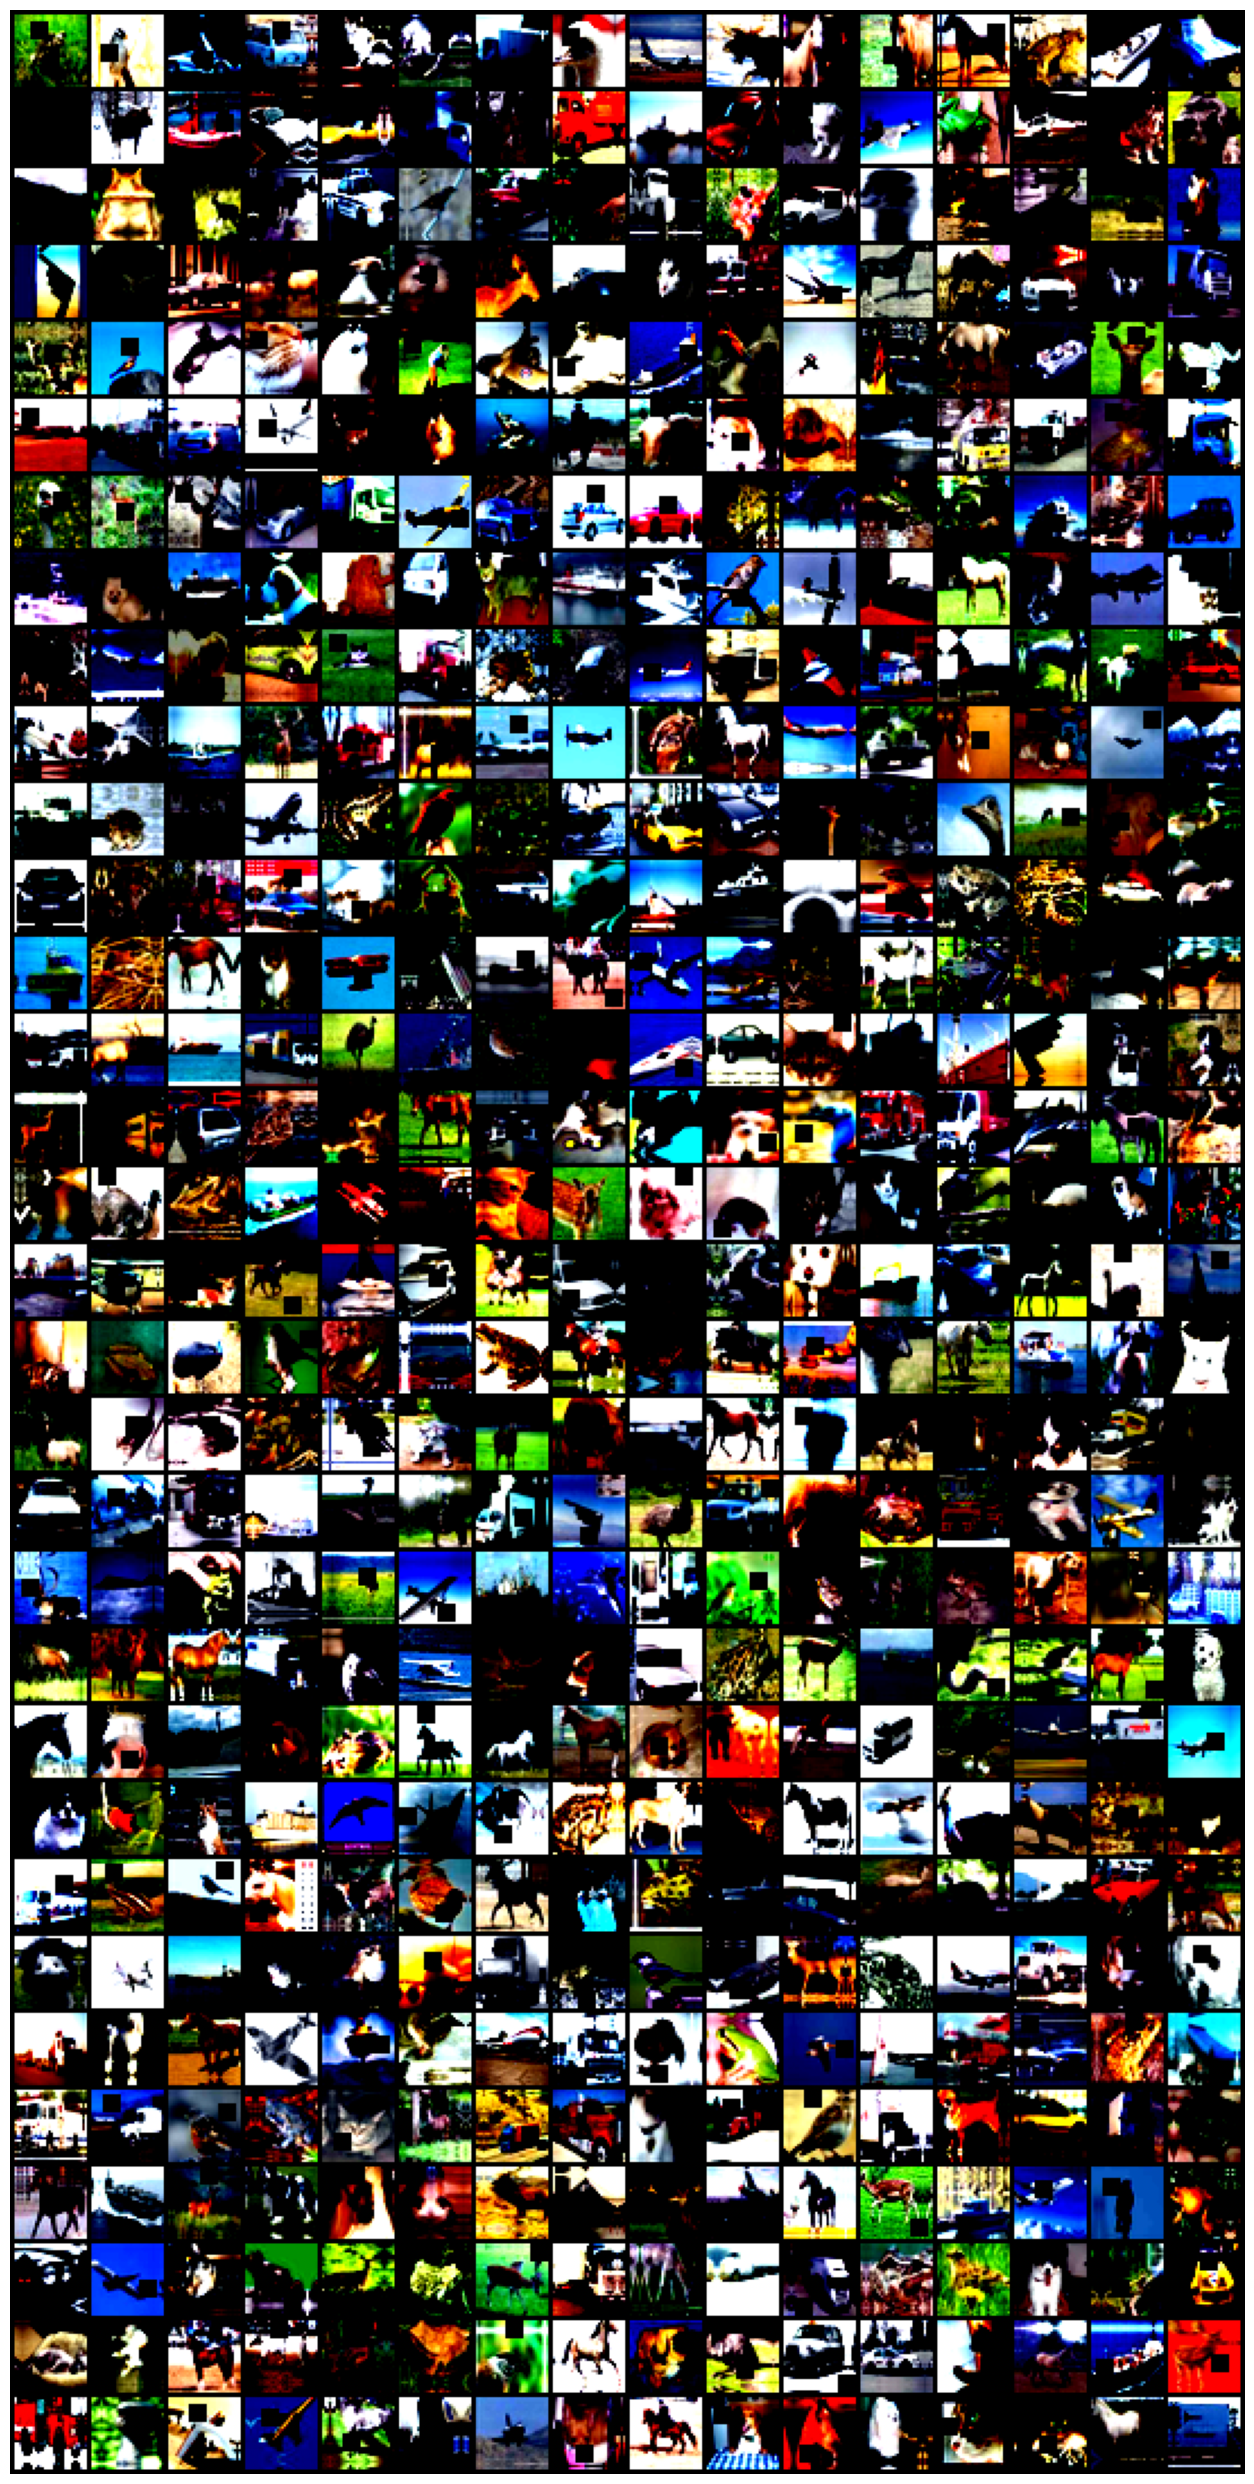

In [7]:
for images, label in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(64,32))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Neural net summary

In [8]:
get_summary(ResNetCustom)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

<function torchsummary.torchsummary.summary(model, input_size, batch_size=-1, device='cuda')>

## Training and testing losses

In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

## LR Finder

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.70E-02


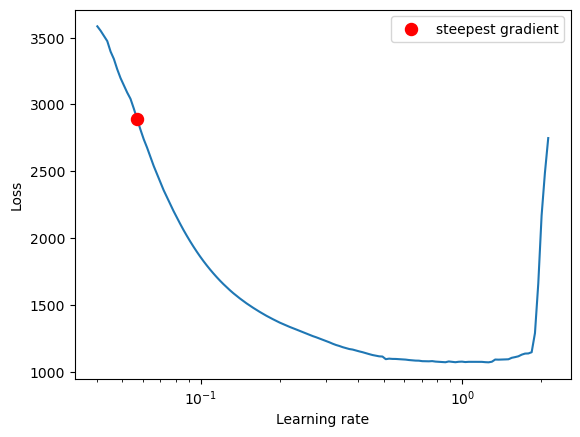

In [13]:
from torch_lr_finder import LRFinder

model = ResNetCustom()
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(reduction="sum")
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

## One cycle LR

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

num_epochs = 24

scheduler = OneCycleLR(optimizer,
        max_lr=5.70E-02,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs,
        pct_start=5/num_epochs,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_acc_val, train_loss = train(model, device, train_loader, optimizer, criterion)
    test_acc_val, test_loss = test(model, device, test_loader, criterion)
    
    train_acc.append(train_acc_val) #Storing training loss for each epoch
    train_losses.append(train_loss)
    test_acc.append(test_acc_val) #Storing testing loss for each epoch
    test_losses.append(test_loss)
    
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

Epoch 1


Train: Loss=407.8254 Batch_id=97 Accuracy=46.97: 100%|█| 98/98 [18:11<00:00, 11.


Test set: Average loss: 584.9633, Accuracy: 5956/10000 (59.56%)

Epoch 1: SGD lr 0.0006 -> 0.0007
Epoch 2


Train: Loss=283.7369 Batch_id=97 Accuracy=66.10: 100%|█| 98/98 [17:48<00:00, 10.


Test set: Average loss: 404.4996, Accuracy: 7168/10000 (71.68%)

Epoch 2: SGD lr 0.0007 -> 0.0008
Epoch 3


Train: Loss=206.6543 Batch_id=97 Accuracy=74.62: 100%|█| 98/98 [23:09<00:00, 14.


Test set: Average loss: 383.2587, Accuracy: 7366/10000 (73.66%)

Epoch 3: SGD lr 0.0008 -> 0.0009
Epoch 4


Train: Loss=239.9870 Batch_id=97 Accuracy=79.17: 100%|█| 98/98 [20:05<00:00, 12.


Test set: Average loss: 314.0240, Accuracy: 7904/10000 (79.04%)

Epoch 4: SGD lr 0.0009 -> 0.0010
Epoch 5


Train: Loss=159.8551 Batch_id=97 Accuracy=82.01: 100%|█| 98/98 [19:31<00:00, 11.


Test set: Average loss: 234.6087, Accuracy: 8455/10000 (84.55%)

Epoch 5: SGD lr 0.0010 -> 0.0011
Epoch 6


Train: Loss=164.1177 Batch_id=97 Accuracy=84.24: 100%|█| 98/98 [18:48<00:00, 11.


Test set: Average loss: 256.3628, Accuracy: 8264/10000 (82.64%)

Epoch 6: SGD lr 0.0011 -> 0.0013
Epoch 7


Train: Loss=127.9498 Batch_id=97 Accuracy=85.90: 100%|█| 98/98 [19:11<00:00, 11.


Test set: Average loss: 221.8684, Accuracy: 8548/10000 (85.48%)

Epoch 7: SGD lr 0.0013 -> 0.0014
Epoch 8


Train: Loss=111.6589 Batch_id=97 Accuracy=87.29: 100%|█| 98/98 [21:06<00:00, 12.


Test set: Average loss: 228.8504, Accuracy: 8486/10000 (84.86%)

Epoch 8: SGD lr 0.0014 -> 0.0015
Epoch 9


Train: Loss=85.9245 Batch_id=97 Accuracy=87.75: 100%|█| 98/98 [22:00<00:00, 13.4


Test set: Average loss: 242.1222, Accuracy: 8410/10000 (84.10%)

Epoch 9: SGD lr 0.0015 -> 0.0016
Epoch 10


Train: Loss=110.8084 Batch_id=97 Accuracy=88.89: 100%|█| 98/98 [20:42<00:00, 12.


Test set: Average loss: 207.2463, Accuracy: 8619/10000 (86.19%)

Epoch 10: SGD lr 0.0016 -> 0.0017
Epoch 11


Train: Loss=135.2914 Batch_id=97 Accuracy=89.82: 100%|█| 98/98 [19:13<00:00, 11.


Test set: Average loss: 206.0153, Accuracy: 8715/10000 (87.15%)

Epoch 11: SGD lr 0.0017 -> 0.0018
Epoch 12


Train: Loss=97.1739 Batch_id=97 Accuracy=90.38: 100%|█| 98/98 [18:33<00:00, 11.3


Test set: Average loss: 203.7939, Accuracy: 8704/10000 (87.04%)

Epoch 12: SGD lr 0.0018 -> 0.0020
Epoch 13


Train: Loss=129.0105 Batch_id=76 Accuracy=90.84:  79%|▊| 77/98 [32:08:49<13:39:0

## Plots

In [ ]:
plot_loss(train_losses, train_acc, test_losses, test_acc)

## Misclassified dataset

In [ ]:
model.eval()

incorrect_examples = []
incorrect_labels = []
incorrect_pred = []

for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True) 
    idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
    if idxs_mask.numel(): 
        incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
        incorrect_labels.append(target[idxs_mask].cpu().numpy())
        incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy())

In [ ]:
print(incorrect_labels[0])
print(incorrect_pred[0])

## Sample misclassified images

In [ ]:
import numpy as np
fig = plt.figure(figsize=(20, 8))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = incorrect_examples[0][idx]
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(incorrect_examples[0][idx], (1, 2, 0)))
    ax.set_title(f"Predicted label: {classes[incorrect_pred[0][idx]]}\n Actual label: {classes[incorrect_labels[0][idx]]}")